In [44]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle
import random

import torch


with open('./TSFresh/TSFresh_user.pickle', 'rb') as handle:
    extracted_features = pickle.load(handle)

with open('./TSFresh/TSFresh_movie.pickle', 'rb') as handle:
    extracted_features_movie = pickle.load(handle)
    
extracted_features.shape,extracted_features_movie.shape 

((2113, 3148), (5908, 3148))

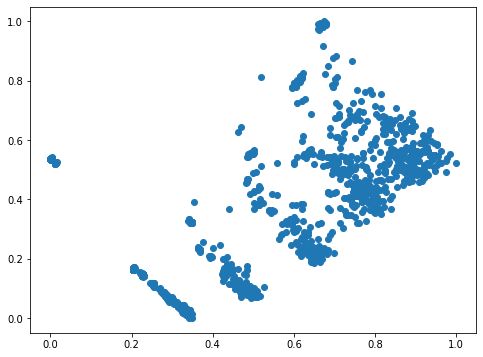

In [2]:
scaler = MinMaxScaler()
tsf_u = scaler.fit_transform(extracted_features)
vectors_u = PCA().fit_transform(tsf_u) #高维度PCA降维到2维 (2113, 2113)
scaler = MinMaxScaler()
vectors_u = scaler.fit_transform(vectors_u)
plt.rcParams["figure.figsize"] = (8, 6)
plt.scatter(vectors_u[:,0],vectors_u[:,1])

In [3]:
# tsf_u = pd.DataFrame(tsf_u) # normalized Tsfresh
tsf_u = pd.DataFrame(vectors_u) # pca-ed normalized Tsfresh
# tsf_u.columns = extracted_features.columns
tsf_u

,0,1,2,3,4,5,6,7,8,9,...,2103,2104,2105,2106,2107,2108,2109,2110,2111,2112
0,0.001978,0.532089,0.413330,0.419155,0.522307,0.302255,0.525024,0.447603,0.717282,0.388285,...,0.477963,0.480385,0.470837,0.472077,0.452186,0.442542,0.844333,0.792380,0.000000,0.378191
1,0.002737,0.536690,0.398483,0.425093,0.348854,0.599924,0.357911,0.469816,0.433190,0.353071,...,0.476673,0.481642,0.470300,0.476707,0.452466,0.437674,0.562808,0.524064,0.448394,0.389506
2,0.336971,0.009305,0.530775,0.398144,0.558838,0.543072,0.171004,0.285683,0.661792,0.153148,...,0.477964,0.480385,0.470834,0.472077,0.452184,0.442543,0.472307,0.455640,0.369631,0.210050
3,0.001599,0.532442,0.412076,0.440361,0.501886,0.464812,0.430897,0.404673,0.725247,0.386177,...,0.479596,0.487311,0.468937,0.467551,0.459075,0.440172,0.156245,0.906810,0.224908,0.339860
4,0.610199,0.798435,0.049318,0.387034,0.406658,0.561489,0.618178,0.268419,0.851702,0.097391,...,0.477674,0.466969,0.473862,0.473802,0.458121,0.444570,0.405125,0.462176,0.397831,0.224506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2108,0.767132,0.356529,0.403029,0.058665,0.529583,0.391045,0.532994,0.244062,0.786784,0.205831,...,0.477964,0.480385,0.470834,0.472077,0.452184,0.442543,0.472307,0.455640,0.369631,0.210050
2109,0.838741,0.467685,0.681586,0.355869,0.429761,0.583599,0.872350,0.566397,0.423050,0.392082,...,0.477964,0.480385,0.470834,0.472077,0.452184,0.442543,0.472307,0.455640,0.369631,0.210050
2110,0.002896,0.535669,0.403572,0.412560,0.400039,0.466905,0.482453,0.492204,0.360334,0.350187,...,0.441425,0.369066,0.609792,0.465568,0.636274,0.570118,0.443724,0.432721,0.384005,0.198533
2111,0.203523,0.162505,0.408079,0.603701,0.360662,0.593451,0.479889,0.352302,0.772599,0.256994,...,0.461932,0.479838,0.456498,0.364937,0.468265,0.379777,0.575766,0.434704,0.348521,0.250015


# User Level hash
Use tsf

In [16]:
同样的网络结构给Product level, 然后再用一个网络让user的hash和product hash联系

tensor([ 1.,  1., -1.,  0., -1.])

In [273]:
class SimpleHash(torch.nn.Module):
    def __init__(self):
        super(SimpleHash, self).__init__()
        self.hash = torch.nn.Sequential(
#             nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.Linear(2113, 256),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.2), # new
            torch.nn.Linear(256, 16),
            torch.nn.ReLU(inplace=True) #new
#             torch.nn.Softmax()
        )

        
#     def hashcode(h):
#         return torch.sign(h)

    def forward(self, x, y):
        x1 = torch.sign(self.hash(x))
        x2 = torch.sign(self.hash(y))
#         x = torch.cat((x1, x2), 1)
#         cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
#         output = cos(x1, x2)
        output = jaccard_distance_loss(x1, x2)
        
        return output 

model = SimpleHash()

print('The model:')
print(model)

The model:
SimpleHash(
  (hash): Sequential(
    (0): Linear(in_features=2113, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=16, bias=True)
    (4): ReLU(inplace=True)
  )
)


In [116]:
# BATCH_SIZE = 1
# DIM_IN = 2113
# DIM_OUT = 16
input_1 = torch.Tensor([tsf_u.iloc[0,:]])
input_2 = torch.Tensor([tsf_u.iloc[2,:]])
# ideal_output = torch.randn(BATCH_SIZE, DIM_OUT, requires_grad=False)

In [255]:
# ideal cosine
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
ideal_cos = cos(input_1, input_2)
ideal_cos

tensor([0.9821])

In [216]:
def jaccard_distance_loss(y_true, y_pred, smooth=0):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/17cbfe0b68148d129a3ddaa227696496
    @author: wassname
    """
    intersection= (y_true * y_pred).abs().sum(dim=-1)
    sum_ = torch.sum(y_true.abs() + y_pred.abs(), dim=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
#     return (1 - jac) * smooth
    return jac

In [274]:
model.hash(input_2)

tensor([[0.0000, 0.0049, 0.0073, 0.0106, 0.0000, 0.2657, 0.0393, 0.0000, 0.0242,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0650, 0.0000, 0.1044]],
       grad_fn=<ReluBackward1>)

In [277]:
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
hash1 = torch.sign(model.hash(input_1))
hash2 = torch.sign(model.hash(input_2))
hash1, hash2

(tensor([[1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1.]],
        grad_fn=<SignBackward>),
 tensor([[0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.]],
        grad_fn=<SignBackward>))

In [222]:
jac = jaccard_distance_loss(hash1, hash2)
jac

tensor([0.6000], grad_fn=<DivBackward0>)

In [253]:
learning_rate = 1e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
prediction = model(input_1, input_2)

print(prediction)
loss = (ideal_cos - prediction)
print(loss)

tensor([0.6364], grad_fn=<DivBackward0>)
tensor([0.3458], grad_fn=<SubBackward0>)


In [93]:
prediction.shape

torch.Size([1])

In [159]:
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
model.hash(input_2)

tensor([[0.1089, 0.0540, 0.0000, 0.0536, 0.0467, 0.0000, 0.0977, 0.0000, 0.0000,
         0.0000, 0.0860, 0.0000, 0.0645, 0.1011, 0.0241, 0.0000]],
       grad_fn=<ReluBackward1>)

In [160]:
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
torch.sign(model.hash(input_2))

tensor([[1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0.]],
       grad_fn=<SignBackward>)

In [161]:
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
torch.sign(model.hash(input_1))

tensor([[1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0.]],
       grad_fn=<SignBackward>)

In [289]:
# Construct Training Set
TRAIN_SAMPLE = 10000

train_index = set()
for i in range(TRAIN_SAMPLE):
    pair = tuple(np.random.choice(tsf_u.index, size=2, replace=False))
    train_index.add(pair)

In [292]:
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
model = SimpleHash()

learning_rate = 1e-4

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch = 3
batch_size = 256
train_id = 0
losses = []
batch_loss = torch.Tensor([0])
for e in range(epoch):
    for i in train_index:
        train_id += 1
        input_1 = torch.Tensor([tsf_u.iloc[i[0],:]])
        input_2 = torch.Tensor([tsf_u.iloc[i[1],:]])

        prediction = model(input_1, input_2)

        ideal_cos = cos(input_1, input_2)

        # Compute and print loss
        single_loss = torch.abs(ideal_cos - prediction)
#         print(train_id, single_loss.item())
        batch_loss += single_loss      
        if train_id%batch_size==0:
            batch_loss = batch_loss / batch_size
            losses.append(batch_loss.item())
            print(train_id, batch_loss.item())
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            batch_loss = torch.Tensor([0])

256 0.13961952924728394
512 0.0338042750954628
768 0.01649634540081024
1024 0.0141214020550251
1280 0.01600348763167858
1536 0.015539904125034809
1792 0.01575206220149994
2048 0.014776617288589478
2304 0.01613745465874672
2560 0.015662960708141327
2816 0.015986207872629166
3072 0.0158804040402174
3328 0.01617315784096718
3584 0.015966525301337242
3840 0.014764617197215557
4096 0.014514939859509468
4352 0.014756597578525543
4608 0.013434034772217274
4864 0.013040712103247643
5120 0.013866089284420013
5376 0.012434221804141998
5632 0.01328396238386631
5888 0.013531038537621498
6144 0.013222802430391312
6400 0.013540378771722317
6656 0.01300823874771595
6912 0.012420603074133396
7168 0.013354937545955181
7424 0.01324877142906189
7680 0.014377867802977562
7936 0.013076504692435265
8192 0.012854548171162605
8448 0.012125633656978607
8704 0.01485853549093008
8960 0.013679135590791702
9216 0.012962092645466328
9472 0.012849757447838783
9728 0.012663707137107849
9984 0.012524603866040707
10240

In [144]:
# 使用dataLoader
from torch.utils.data import WeightedRandomSampler, DataLoader
a = torch.Tensor([1,2,3])
dataloader = DataLoader(dataset = a, batch_size=2,
                        sampler=WeightedRandomSampler(torch.ones(a.size()),10))
for i in dataloader:
    print(i)

tensor([1., 3.])
tensor([1., 1.])
tensor([1., 2.])
tensor([3., 3.])
tensor([1., 3.])


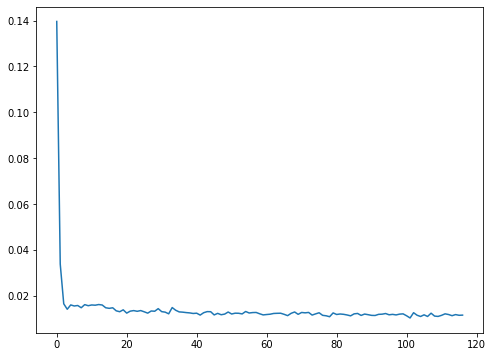

In [293]:
plt.plot(losses) # adam, 10000, 3epo, 256-batch # new (two-fc relu, 1-dropout0.2)

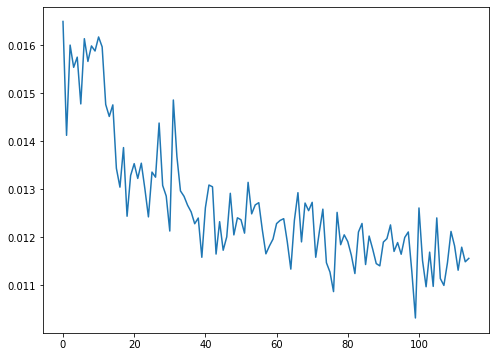

In [299]:
plt.plot(losses[2:])

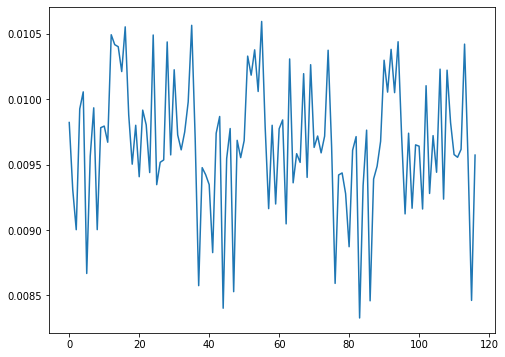

In [248]:
plt.plot(losses) # SGD, 10000, 3epo, 256-batch

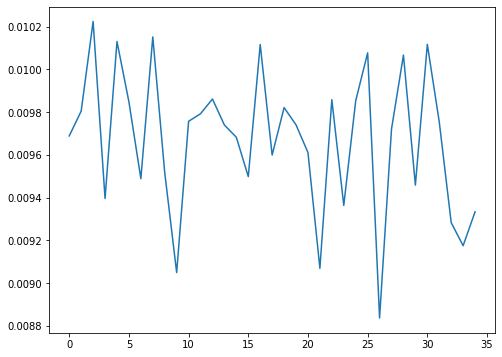

In [245]:
plt.plot(losses) # SGD, 3000, 3epo, 256-batch

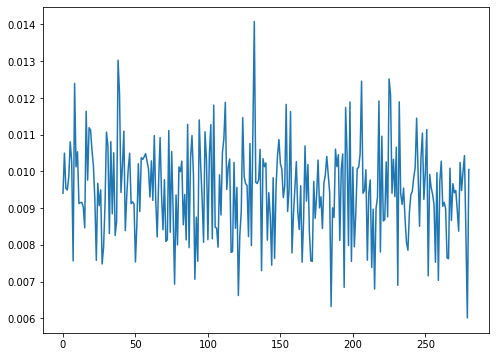

In [243]:
plt.plot(losses) # SGD, 3000, 3epo, 32-batch

# Instance level hash
Manual feature

In [249]:
df = pd.read_csv('./user_taggedmovies.dat',sep="\s+", )
# df.iloc[:,1] = 'I-'+df.iloc[:,1].astype('str')
df.loc[:,'timestamps'] = df.date_year.astype('str')+'_'+ df.date_month.astype('str')+'_'+ df.date_day.astype('str')+'_'+ \
df.date_hour.astype('str')+'_'+df.date_minute.astype('str')+'_'+df.date_second.astype('str')

df.loc[:,'timestamps'] = df.loc[:,'timestamps'].apply(pd.to_datetime,format='%Y_%m_%d_%H_%M_%S')
df['dayofweek_num']=df['timestamps'].dt.dayofweek  
df['weekofyear']=df['timestamps'].dt.weekofyear
df['quarter']=df['timestamps'].dt.quarter
df['days_in_month']=df['timestamps'].dt.days_in_month
df['is_month_start']=df['timestamps'].dt.is_month_start
df['is_month_end']=df['timestamps'].dt.is_month_end
df['is_quarter_start']=df['timestamps'].dt.is_quarter_start
df['is_quarter_end']=df['timestamps'].dt.is_quarter_end
df['is_year_start']=df['timestamps'].dt.is_year_start
df['is_year_end']=df['timestamps'].dt.is_year_end
df['is_leap_year']=df['timestamps'].dt.is_leap_year
df

/tmp/ipykernel_1726589/4083897538.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear']=df['timestamps'].dt.weekofyear


,userID,movieID,tagID,date_day,date_month,date_year,date_hour,date_minute,date_second,timestamps,...,weekofyear,quarter,days_in_month,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_leap_year
0,75,353,5290,29,10,2006,23,20,15,2006-10-29 23:20:15,...,43,4,31,False,False,False,False,False,False,False
1,78,4223,5264,16,4,2007,4,43,45,2007-04-16 04:43:45,...,16,2,30,False,False,False,False,False,False,False
2,127,1343,1544,28,8,2007,3,42,27,2007-08-28 03:42:27,...,35,3,31,False,False,False,False,False,False,False
3,127,1343,12330,28,8,2007,3,42,27,2007-08-28 03:42:27,...,35,3,31,False,False,False,False,False,False,False
4,127,2080,1451,28,8,2007,3,42,47,2007-08-28 03:42:47,...,35,3,31,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47952,71534,7937,306,3,12,2007,3,7,14,2007-12-03 03:07:14,...,49,4,31,False,False,False,False,False,False,False
47953,71534,8848,331,3,12,2007,3,6,19,2007-12-03 03:06:19,...,49,4,31,False,False,False,False,False,False,False
47954,71534,8848,427,3,12,2007,3,6,27,2007-12-03 03:06:27,...,49,4,31,False,False,False,False,False,False,False
47955,71534,25833,7671,3,12,2007,3,7,31,2007-12-03 03:07:31,...,49,4,31,False,False,False,False,False,False,False


In [250]:
df_selected = df.filter(regex="[^time_stamp]")
df_selected = df_selected.iloc[:,:]
cols = df_selected.columns
df_selected

,userID,movieID,tagID,date_day,date_month,date_year,date_hour,date_minute,date_second,dayofweek_num,weekofyear,quarter,days_in_month,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_leap_year
0,75,353,5290,29,10,2006,23,20,15,6,43,4,31,False,False,False,False,False,False,False
1,78,4223,5264,16,4,2007,4,43,45,0,16,2,30,False,False,False,False,False,False,False
2,127,1343,1544,28,8,2007,3,42,27,1,35,3,31,False,False,False,False,False,False,False
3,127,1343,12330,28,8,2007,3,42,27,1,35,3,31,False,False,False,False,False,False,False
4,127,2080,1451,28,8,2007,3,42,47,1,35,3,31,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47952,71534,7937,306,3,12,2007,3,7,14,0,49,4,31,False,False,False,False,False,False,False
47953,71534,8848,331,3,12,2007,3,6,19,0,49,4,31,False,False,False,False,False,False,False
47954,71534,8848,427,3,12,2007,3,6,27,0,49,4,31,False,False,False,False,False,False,False
47955,71534,25833,7671,3,12,2007,3,7,31,0,49,4,31,False,False,False,False,False,False,False


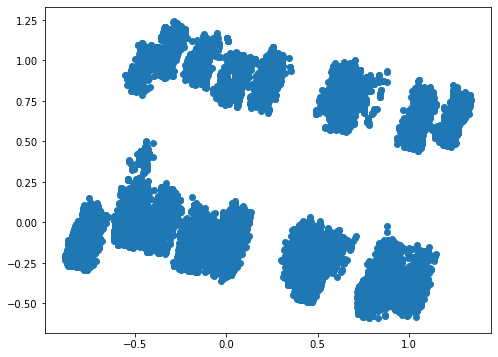

In [251]:
# instance level
scaler = MinMaxScaler()
df_selected = scaler.fit_transform(df_selected)
df_selected = pd.DataFrame(df_selected)
df_selected.columns = cols
# scaler.inverse_transform(df_selected)

vectors = PCA().fit_transform(df_selected) #高维度PCA降维到2维
plt.rcParams["figure.figsize"] = (8, 6)
plt.scatter(vectors[:,0],vectors[:,1]) # user

In [253]:
vectors.shape

(47957, 20)

In [255]:
df_v = pd.DataFrame(vectors)
df_v

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.778900,-0.390593,-0.098829,-0.458653,0.470913,-0.256958,-0.212483,-0.410520,0.564576,-0.139185,-0.218929,0.148684,-0.128585,-0.047232,0.030688,0.039357,-0.080864,0.015704,0.021929,0.003722
1,-0.230161,-0.147969,0.112037,0.511991,-0.226616,0.350031,0.196433,0.136389,0.394739,-0.190950,-0.200348,0.000119,-0.009765,0.114033,0.011540,0.028930,-0.072680,-0.005985,0.027297,0.002902
2,0.437038,-0.293217,0.143673,0.376244,-0.310628,0.269440,-0.141746,-0.257566,0.442297,-0.339326,-0.227831,0.115553,-0.108273,0.168015,-0.031420,0.004834,0.005896,-0.010202,0.005003,0.001332
3,0.433572,-0.247804,0.162322,0.415571,-0.238904,0.256598,-0.114161,-0.125988,0.706146,0.210775,-0.385175,0.114953,-0.114221,0.130775,-0.027135,0.003633,-0.001310,-0.004669,0.008588,0.001404
4,0.437727,-0.292543,0.136247,0.377923,-0.289057,0.403695,0.165686,-0.295859,0.428784,-0.340092,-0.209056,0.116836,-0.107942,0.166660,-0.031042,0.005556,0.005845,-0.010220,0.004901,0.001317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47952,1.053859,-0.428019,0.044534,0.470231,-0.422787,-0.452232,-0.041792,0.313865,-0.497557,-0.049565,-0.016883,-0.215233,0.094000,0.130193,-0.013911,-0.038612,0.056368,-0.005809,-0.010618,-0.002090
47953,1.054949,-0.424848,0.044011,0.473541,-0.417285,-0.434113,0.041430,0.301842,-0.497878,-0.045700,-0.002753,-0.215096,0.093715,0.129401,-0.013609,-0.038355,0.056327,-0.005773,-0.010672,-0.002073
47954,1.054797,-0.424990,0.040631,0.474473,-0.407703,-0.380465,0.164677,0.287763,-0.501026,-0.039709,-0.001364,-0.214522,0.093923,0.128582,-0.013418,-0.038091,0.056216,-0.005704,-0.010669,-0.002085
47955,1.074581,-0.339169,0.088615,0.512015,-0.358907,-0.353094,0.242431,0.394788,-0.268329,0.358495,0.135245,-0.218552,0.081468,0.092630,-0.009904,-0.038208,0.051455,-0.002497,-0.008170,-0.001686


In [283]:
class SimpleHash(torch.nn.Module):
    def __init__(self):
        super(SimpleHash, self).__init__()
        self.hash = torch.nn.Sequential(
#             nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.Linear(20, 16),
            torch.nn.ReLU(inplace=True)
#             torch.nn.Dropout(0.2), # new
#             torch.nn.Linear(16, 8), # new
#             torch.nn.Softmax()
        )

    def forward(self, x, y):
        x1 = self.hash(x)
        x2 = self.hash(y)
#         x = torch.cat((x1, x2), 1)
        cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
        output = cos(x1, x2)
        return output 

model = SimpleHash()

print('The model:')
print(model)

The model:
SimpleHash(
  (hash): Sequential(
    (0): Linear(in_features=20, out_features=16, bias=True)
    (1): ReLU(inplace=True)
  )
)


In [271]:
# Construct Training Set
TRAIN_SAMPLE = 10000
import random
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

train_index = set()
for i in range(TRAIN_SAMPLE):
    pair = tuple(np.random.choice(df_v.index, size=2, replace=False))
    train_index.add(pair)

In [286]:
import random
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
model = SimpleHash()

learning_rate = 1e-4

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch = 5
batch_size = 256
train_id = 0
losses = []
batch_loss = torch.Tensor([0])
for e in range(epoch):
    for i in train_index:
        train_id += 1
        input_1 = torch.Tensor([df_v.iloc[i[0],:]])
        input_2 = torch.Tensor([df_v.iloc[i[1],:]])

        prediction = model(input_1, input_2)

        ideal_cos = cos(input_1, input_2)

        # Compute and print loss
        single_loss = torch.abs(ideal_cos - prediction)
#         print(train_id, single_loss.item())
        batch_loss += single_loss      
        if train_id%batch_size==0:
            batch_loss = batch_loss / batch_size
            losses.append(batch_loss.item())
            print(train_id, batch_loss.item())
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            batch_loss = torch.Tensor([0])

256 0.5925562381744385
512 0.6082743406295776
768 0.6005871891975403
1024 0.621350109577179
1280 0.6267083287239075
1536 0.6000025272369385
1792 0.5896555185317993
2048 0.6072714328765869
2304 0.6034070253372192
2560 0.609420120716095
2816 0.616270124912262
3072 0.6062830686569214
3328 0.6065483093261719
3584 0.6097937822341919
3840 0.5922565460205078
4096 0.5853851437568665
4352 0.6224833130836487
4608 0.6067174077033997
4864 0.566571831703186
5120 0.5764716267585754
5376 0.6132208108901978
5632 0.6087629199028015
5888 0.5974698662757874
6144 0.6192486882209778
6400 0.6351261138916016
6656 0.6147258281707764
6912 0.5815185904502869
7168 0.5874508619308472
7424 0.5751233100891113
7680 0.6009278893470764
7936 0.5927151441574097
8192 0.5989681482315063
8448 0.6087124347686768
8704 0.6123960018157959
8960 0.5844499468803406
9216 0.5796220898628235
9472 0.5883866548538208
9728 0.6038698554039001
9984 0.58480304479599
10240 0.5751761794090271
10496 0.5984166264533997
10752 0.589268982410430

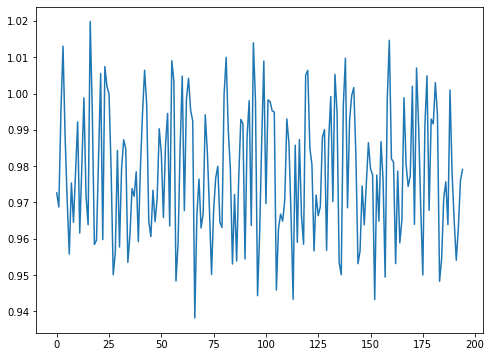

In [269]:
plt.plot(losses) # SGD, 10000, 3epo, 256-batch fc-softmax 16-bit

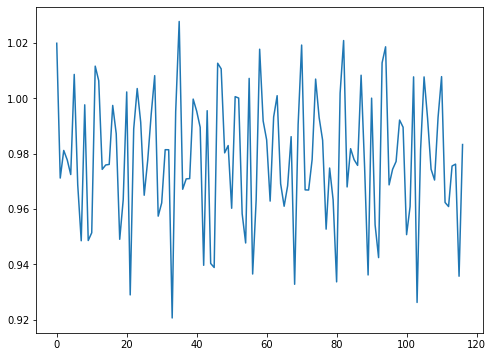

In [266]:
plt.plot(losses) # SGD, 3000, 10epo, 256-batch  fc-softmax 16-bit

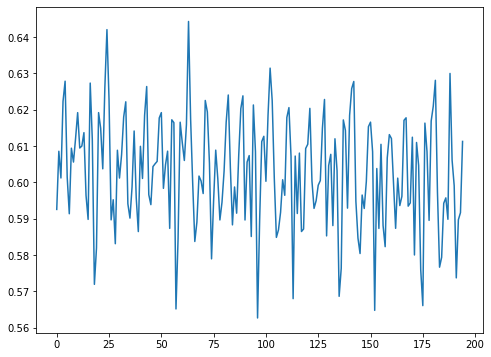

In [285]:
plt.plot(losses) # SGD, 10000, 3epo, 256-batch fc-relu 16-bit

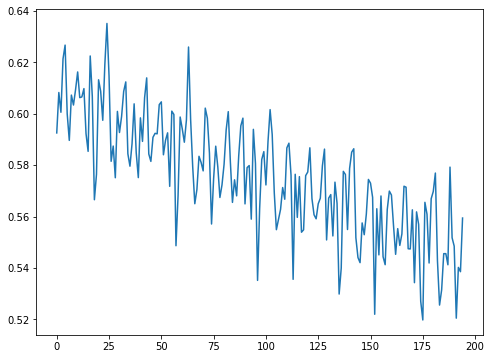

In [287]:
plt.plot(losses) # adam, 10000, 3epo, 256-batch fc-relu 16-bit

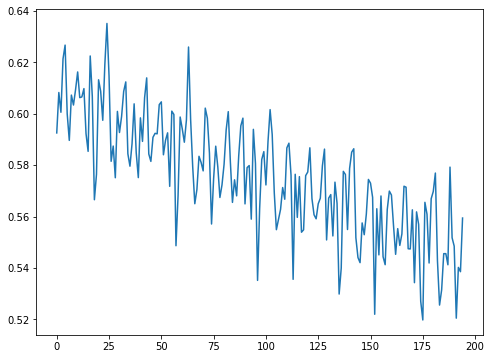

In [274]:
plt.plot(losses) # adam, 10000, 3epo, 256-batch fc-relu 16-bit

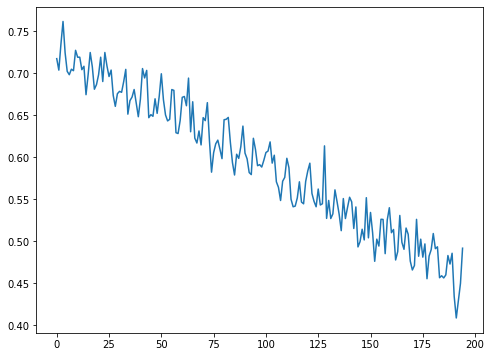

In [281]:
plt.plot(losses) # adam, 10000, 3epo, 256-batch fc-relu # new  (add dropu out, 8-bit)